In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.2/Aprendizagem de Maquina/trabalho_02/')

Mounted at /content/drive


# Imports

In [2]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import math
import scipy
from mpl_toolkits import mplot3d
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
from IPython.display import display

import matplotlib.pyplot as plt

In [3]:
def transform(x):
    if x == 'setosa':
        return 0
    elif x == 'virginica':
        return 1
    elif x == 'versicolor':
        return 2

In [4]:
df_iris = sns.load_dataset('iris')
df_iris['target'] = df_iris['species'].apply(lambda x: transform(x))
df_iris.drop(['species'], axis=1, inplace=True)

In [5]:
df_iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


# univariada

In [6]:
class NormalUnivariate():

    def __init__(self, array):
        self.array = array
        self.mean = np.mean(array)
        self.std = np.std(array)
        self.var = self.std ** 2
        self.peak_distribution = 1 / (np.sqrt(2 * np.pi * self.var))

    def pdf(self, x):
        if isinstance(x, list) or isinstance(x, np.ndarray):
            return [self.peak_distribution * (np.exp(-(i - self.mean) ** 2 / (2 * self.var))) for i in x]

        return self.peak_distribution * (np.exp(-(x - self.mean) ** 2 / (2 * self.var)))

    def plot_pdf(self, x=None):
        if x is None:
            xmin, xmax = min(self.array), max(self.array)
            x = np.linspace(xmin, xmax, 100)

        probabilities = self.pdf(x)
        plt.hist(array, density=True, color='g', alpha=0.6, bins=18)
        plt.plot(x, probabilities, 'k', linewidth=2)
        plt.title(f'Média = {self.mean},  std = {self.std}')
        plt.show()

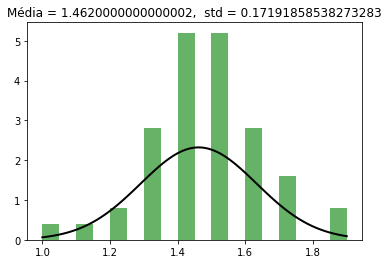

In [7]:
array = df_iris[df_iris['target'] == 0]['petal_length'].tolist()

norm = NormalUnivariate(array)
norm.plot_pdf()

In [8]:
norm.pdf(1.4)

2.174430137613872

# Multivariada

In [9]:
class NormalMultivariate():

    def __init__(self, df):
        self.df = df
        self.dim = len(df.columns)
        self.mean = np.array([df[col].mean() for col in df.columns  if col != 'target'])
        self.cov = np.matrix(df.cov().values)
        self.det = np.linalg.det(self.cov)
        self.peak_distribution = 1 / (((2 * np.pi) ** (self.dim / 2)) * 
                                      (self.det ** 0.5))

    def pdf(self, x):
        if isinstance(x, pd.core.frame.DataFrame) or isinstance(x[0], list) or isinstance(x[0], np.ndarray) or isinstance(x[0], np.matrix):
            if isinstance(x, pd.core.frame.DataFrame):
                x = x.values
            list_return = []
            for i in x:
                list_return.append(self.__pdf_single_list(i))
            return list_return

        else:
            return self.__pdf_single_list(x)

    def __pdf_single_list(self, x):

        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x_mu = np.matrix(x - self.mean)
        inv = self.cov.I        
        return self.peak_distribution * math.pow(math.e, -0.5 * (x_mu * inv * x_mu.T))


    def plot_pdf(self, col_x1, col_x2):
        
        if self.dim > 2:
            raise NameError('Viewing can only be done with 2 attributes')
        x = np.linspace(self.df[col_x1].min(), self.df[col_x1].max(), 100)
        y = np.linspace(self.df[col_x2].min(), self.df[col_x2].max(), 100)
        df = pd.DataFrame(list(zip(x,y)), columns=[col_x1, col_x2])
        z = self.pdf(df)
        df['prob'] = z

        threedee = plt.figure(figsize=(15, 12)).gca(projection='3d')
        threedee.plot(df[col_x1], df[col_x2], df['prob'])
        threedee.set_xlabel(col_x1)
        threedee.set_ylabel(col_x2)
        threedee.set_zlabel('prob')

        plt.title(f'Média = {self.mean},  cov = {self.cov}')
        plt.show()

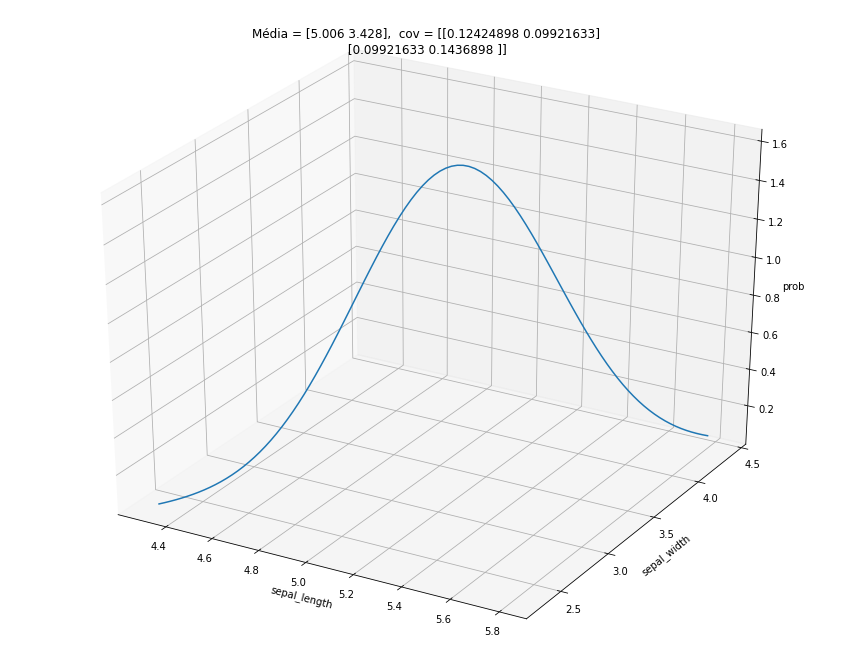

In [10]:
df_class_0 = df_iris[df_iris['target'] == 0].drop(['target'], axis=1)[['sepal_length', 'sepal_width']].copy()

norm = NormalMultivariate(df_class_0)
norm.plot_pdf('sepal_length', 'sepal_width') 

In [11]:
df_class_0 = df_iris[df_iris['target'] == 0].drop(['target'], axis=1).copy()

norm = NormalMultivariate(df_class_0)
df_class_0['proba'] = norm.pdf(df_class_0) 

In [12]:
df_class_0.head(3)

,sepal_length,sepal_width,petal_length,petal_width,proba
0,5.1,3.5,1.4,0.2,13.920591
1,4.9,3.0,1.4,0.2,6.155703
2,4.7,3.2,1.3,0.2,9.168360


# Classificador

In [13]:
def predict(df, verbose=False):

    features = [col for col in df.columns if col != 'target']

    dict_priori = {}
    dict_df_class = {}
    dict_norm_class = {}

    for j in sorted(df['target'].unique()):
        dict_priori[j] = (len(df.loc[df['target'] == j]) / len(df))
        dict_df_class[j] = df[df['target'] == j].copy()
        dict_norm_class[j] = NormalMultivariate(dict_df_class[j][features])   

    if verbose:
        diplay(df)
        print(dict_priori)

    

    list_predict = []
    for idx, row in df.iterrows():

        x = df[features].iloc[idx].tolist()

        pdf_priori = []
        dict_pdf = {}
        for j in sorted(df['target'].unique()):
            verossimilhanca = dict_norm_class[j].pdf(x)
            dict_pdf[j] = verossimilhanca
            pdf_priori.append(
                dict_pdf[j] * dict_priori[j]
            )

        normalize = sum(pdf_priori)
        prob_class = {}
        prob_max = -1
        class_predict = -1
        for j in sorted(df['target'].unique()): 
            prob_class[j] =  (dict_pdf[j] * dict_priori[j]) / normalize
            if prob_class[j] > prob_max:
                prob_max = prob_class[j]
                class_predict = j

        list_predict.append(class_predict)
    
    return list_predict

In [14]:
df_iris['predict'] = predict(df_iris.copy())

In [15]:
def accuracy(y_true, y_pred): # Taxa de acerto
    
    qtd_acertos = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred: 
            qtd_acertos += 1

    return qtd_acertos / len(y_true)

In [16]:
accuracy(df_iris['target'], df_iris['predict'])

0.98

In [17]:
df_iris

,sepal_length,sepal_width,petal_length,petal_width,target,predict
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1,1
146,6.3,2.5,5.0,1.9,1,1
147,6.5,3.0,5.2,2.0,1,1
148,6.2,3.4,5.4,2.3,1,1


In [18]:
df_iris[df_iris['predict'] != df_iris['target']]

,sepal_length,sepal_width,petal_length,petal_width,target,predict
70,5.9,3.2,4.8,1.8,2,1
83,6.0,2.7,5.1,1.6,2,1
133,6.3,2.8,5.1,1.5,1,2
